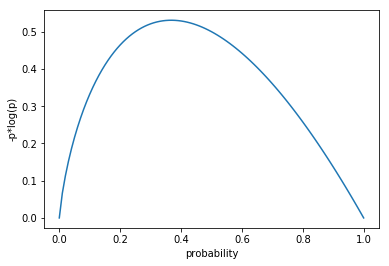

In [2]:
import math
x = [i/100.0 for i in range(101) ]
entropy_x = [0] + [-p*math.log(p,2) for p in x if p > 0]
import matplotlib.pyplot as plt
plt.plot(x, entropy_x)
plt.xlabel('probability')
plt.ylabel('-p*log(p)')
plt.show()

In [3]:
from typing import List

def entropy(class_probabilities: List[float]) -> float:
    """Given a list of class probabilities, computes entropy."""
    return sum(-p*math.log(p,2) 
                for p in class_probabilities 
                if p > 0) # ignore zero probabilties

In [4]:
print(f"entropy([1.0]) = {entropy([1.0])}")
print(f"entropy([0.5, 0.5]) = {entropy([0.5, 0.5])}")
print(f"entropy([0.25, 0.75]) = {entropy([0.25, 0.75])}")

entropy([1.0]) = 0.0
entropy([0.5, 0.5]) = 1.0
entropy([0.25, 0.75]) = 0.8112781244591328


In [5]:
from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

print(f"data_entropy(['a']) = {data_entropy(['a'])}")
print(f"data_entropy([True, False]) = {data_entropy([True, False])}")
print(f"data_entropy([3,4,4,4]) = {data_entropy([3,4,4,4])}")



data_entropy(['a']) = 0.0
data_entropy([True, False]) = 1.0
data_entropy([3,4,4,4]) = 0.8112781244591328


In [6]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count
              for subset in subsets)

In [17]:
from typing import NamedTuple, Optional

class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None # allow unlabeled data
        
                  #  level     lang     tweets  phd  did_well
inputs = [Candidate('Senior', 'Java',   False, False, False),
          Candidate('Senior', 'Java',   False, True,  False),
          Candidate('Mid',    'Python', False, False, True),
          Candidate('Junior', 'Python', False, False, True),
          Candidate('Junior', 'R',      True,  False, True),
          Candidate('Junior', 'R',      True,  True,  False),
          Candidate('Mid',    'R',      True,  True,  True),
          Candidate('Senior', 'Python', False, False, False),
          Candidate('Senior', 'R',      True,  False, True),
          Candidate('Junior', 'Python', True,  False, True),
          Candidate('Senior', 'Python', True,  True,  True),
          Candidate('Mid',    'Python', False, True,  True),
          Candidate('Mid',    'Java',   True,  False, True),
          Candidate('Junior', 'Python', False, True,  False)
         ]

from typing import Dict, TypeVar
from collections import defaultdict

T = TypeVar('T') # generic type for inputs

def partition_by(inputs: List[T], attribute: str) -> Dict[Any, List[T]]:
    """Partition the inputs into lists based on the specified attribute"""
    partitions: Dict[Any, List[T]] = defaultdict(list)
        
    for input in inputs:
        key = getattr(input, attribute) # value of the specified attribute
        partitions[key].append(input)
        
    return partitions

partition = partition_by(inputs, 'level')
print(partition.keys())
print(partition.values())

dict_keys(['Senior', 'Mid', 'Junior'])
dict_values([[Candidate(level='Senior', lang='Java', tweets=False, phd=False, did_well=False), Candidate(level='Senior', lang='Java', tweets=False, phd=True, did_well=False), Candidate(level='Senior', lang='Python', tweets=False, phd=False, did_well=False), Candidate(level='Senior', lang='R', tweets=True, phd=False, did_well=True), Candidate(level='Senior', lang='Python', tweets=True, phd=True, did_well=True)], [Candidate(level='Mid', lang='Python', tweets=False, phd=False, did_well=True), Candidate(level='Mid', lang='R', tweets=True, phd=True, did_well=True), Candidate(level='Mid', lang='Python', tweets=False, phd=True, did_well=True), Candidate(level='Mid', lang='Java', tweets=True, phd=False, did_well=True)], [Candidate(level='Junior', lang='Python', tweets=False, phd=False, did_well=True), Candidate(level='Junior', lang='R', tweets=True, phd=False, did_well=True), Candidate(level='Junior', lang='R', tweets=True, phd=True, did_well=False), Cand

In [ ]:
def partition_entropy_by(inputs: List[Any], 
                         attribute: str,
                         label_attribute: str) -> float:
    """Compute the entropy according to the given partition."""
    # partitions consists of our inputs
    partitions = partition_by(inputs, attribute)
    
    # but partition entropy just needs the class labels
    labels = [[getattr(input, label_attribute) for input in partition]
             for partition in partitions.values()]
    
    return partition_entropy(labels)

In [22]:
print(partition_entropy_by(inputs, 'level', 'did_well'))
print(partition_entropy_by(inputs, 'lang', 'did_well'))
print(partition_entropy_by(inputs, 'tweets', 'did_well'))
print(partition_entropy_by(inputs, 'phd', 'did_well'))

0.6935361388961919
0.8601317128547441
0.7884504573082896
0.8921589282623617


In [27]:
senior_inputs = [input for input in inputs if input.level == 'Senior']

print(partition_entropy_by(senior_inputs, 'lang', 'did_well'))
print(partition_entropy_by(senior_inputs, 'tweets', 'did_well'))
print(partition_entropy_by(senior_inputs, 'phd', 'did_well'))

0.4
0.0
0.9509775004326938


In [29]:
from typing import Union

class Leaf(NamedTuple):
    value: Any
        
class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None
        
DecisionTree = Union[Leaf, Split]

def classify(tree: DecisionTree, input: Any) -> Any:
    """Classify the input using a given decision tree"""
    
    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value()
    
    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values are subtrees to consider next
    subtree_key = getattr(input, tree.attribute)
    
    if subtree_key not in tree.subtrees: # If no subtree for key
        return tree.default_value
    
    subtree = tree.subtrees[subtree_key] # Use the appropriate subtree
    return classify(subtree, input) # and use it to classify the input

In [36]:
def build_tree_id3(inputs: List[Any],
                  split_attributes: str,
                  target_attribute: str) -> DecisionTree:
    
    # Count target labels
    label_counts = Counter(getattr(input, target_attribute)
                          for input in inputs)
    
    most_common_label = label_counts.most_common(1)[0][0]
    
    # If there's a unique label predict it
    
    if len(label_counts) == 1:
        return Leaf(most_common_label)
    
    # If no split attributes left, return the majority label
    if not split_attributes:
        return Leaf(most_common_label)
    
    # Otherwise split by the best attribute
    
    def split_entropy(attribute: str) -> float:
        """Helper function for finding the best attribute"""
        return partition_entropy_by(inputs, attribute, target_attribute)
    
    best_attribute = min(split_attributes, key = split_entropy)
    
    partitions = partition_by(inputs, best_attribute)
    new_attributes  = [a for a in split_attributes if a != best_attribute]
    
    # Recursively build the subtrees
    subtrees = {attribute_value : build_tree_id3(subset,
                                                new_attributes,
                                                target_attribute)
               for attribute_value, subset in partition.items()}
    return Split(best_attribute, subtrees, default_value = most_common_label)



In [42]:
tree = build_tree_id3(inputs, 
                      ['level','lang','tweets','phd'],
                      'did_well')

print(classify(tree, Candidate("Junior", "Java", True, False)))

print(classify(tree, Candidate("Junior", "Java", True, True)))

print(classify(tree, Candidate("Intern", "Java", True, True)))

True
True
True
